In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../../..")
from utils import utils, postprocessing_utils as post
from utils.plotting_utils import plots

In [2]:
def group_transfer(task, short_model_name, metric, grouped_train=True, grouped_test=True):
    params = {
        "results_dir": "../../../results/",
        "experiment": "acl",
        "short_model_name": short_model_name,
        "task": task,
        "metric": metric
    }

    M = post.Metrics(**params)
    df = M.transfer_loss(grouped_train=grouped_train, grouped_test=grouped_test)
    df_same = df[df["Train-Group"] == df["Test-Group"]]
    df_others = df[df["Train-Group"] != df["Test-Group"]]
    df_same.loc[:, "Test-Group"] = "Intra-Group"
    if grouped_train:
        df_others = df_others.groupby("Train-Group", sort=False, as_index=False).mean()
    df_others["Test-Group"] = "Inter-Group"

    final = pd.concat([df_same, df_others]).reset_index(drop=True)
    final.loc[:, ["Within-Score", "Cross-Score", "Transfer-Loss"]] *= 100
    if task == "pos":
        final["Task"] = "Part-of-Speech"
    elif task == "sentiment":
        final["Task"] = "Sentiment Analysis"
    if short_model_name == "mbert":
        final["Model"] = "mBERT"
    elif short_model_name == "xlm-roberta":
        final["Model"] = "XLM"
    return final

In [3]:
df = pd.DataFrame()

for task, metric in [("pos", "Accuracy"), ("sentiment", "Macro_F1")]:
    for short_model_name in ["mbert", "xlm-roberta"]:
        temp = group_transfer(task, short_model_name, metric)
        temp = temp.groupby(["Test-Group", "Task", "Model"], sort=False, as_index=False).mean()
        df = pd.concat([df, temp], ignore_index=True)

e:\anaconda\envs\tfm_ccil\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
df

,Test-Group,Task,Model,Within-Score,Cross-Score,Transfer-Loss
0,Intra-Group,Part-of-Speech,mBERT,94.480404,61.008375,33.472029
1,Inter-Group,Part-of-Speech,mBERT,94.480404,53.691829,40.788575
2,Intra-Group,Part-of-Speech,XLM,94.650021,63.327071,31.322951
3,Inter-Group,Part-of-Speech,XLM,94.650021,55.879560,38.770461
4,Intra-Group,Sentiment Analysis,mBERT,85.312534,55.292303,30.020231
5,Inter-Group,Sentiment Analysis,mBERT,85.312534,52.282034,33.030500
6,Intra-Group,Sentiment Analysis,XLM,87.879428,68.348204,19.531224
7,Inter-Group,Sentiment Analysis,XLM,87.879428,65.750835,22.128593


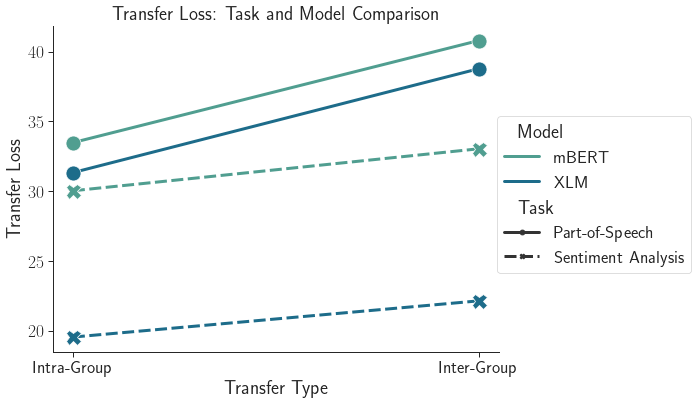

In [5]:
plots.prepare_sns()
sns.set_context("paper", font_scale=2)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

#colors = {sns.desaturate(c, 0.25) for c in plots.get_dual_bar_colors()}

g1 = sns.lineplot(x="Test-Group", 
                  y="Transfer-Loss", 
                  hue="Model", 
                  data=df,
                  palette="crest", 
                  linewidth=3, 
                  ax=ax, 
                  legend=True, 
                  dashes=True, 
                  style="Task", 
                  markers=True, 
                  markersize=15)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.95, 0.25, 0.5, 0.5))

for i in range(6):
    leg.legendHandles[i].set_linewidth(3)
    
ax.set_title("Transfer Loss: Task and Model Comparison")
ax.set_xlabel("Transfer Type")
ax.set_ylabel("Transfer Loss")

sns.despine()
plt.show()
fig.savefig("../../../results/acl/plots/task_comparison.pdf", dpi=400, bbox_inches="tight")
plt.close()

In [6]:
df = pd.DataFrame()

for task, metric in [("pos", "Accuracy"), ("sentiment", "Macro_F1")]:
    for short_model_name in ["mbert", "xlm-roberta"]:
        temp = group_transfer(task, short_model_name, metric, grouped_train=False, grouped_test=False)
        df = pd.concat([df, temp], ignore_index=True)

e:\anaconda\envs\tfm_ccil\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
e:\anaconda\envs\tfm_ccil\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
df

,Train-Group,Train-Language,Within-Score,Test-Group,Test-Language,Cross-Score,Transfer-Loss,Task,Model
0,Fusional,German,98.244598,Intra-Group,Spanish,84.475673,13.768925,Part-of-Speech,mBERT
1,Fusional,German,98.244598,Intra-Group,Slovak,82.929076,15.315522,Part-of-Speech,mBERT
2,Fusional,German,98.244598,Intra-Group,Norwegian,87.385704,10.858894,Part-of-Speech,mBERT
3,Fusional,German,98.244598,Intra-Group,Greek,80.445224,17.799373,Part-of-Speech,mBERT
4,Fusional,Spanish,98.823886,Intra-Group,German,82.293946,16.529940,Part-of-Speech,mBERT
...,...,...,...,...,...,...,...,...,...
1291,Introflexive,Maltese,62.371542,Inter-Group,Finnish,46.028527,16.343014,Sentiment Analysis,XLM
1292,Introflexive,Maltese,62.371542,Inter-Group,Basque,44.088670,18.282872,Sentiment Analysis,XLM
1293,Introflexive,Maltese,62.371542,Inter-Group,Korean,52.250039,10.121502,Sentiment Analysis,XLM
1294,Introflexive,Maltese,62.371542,Inter-Group,Japanese,56.551655,5.819886,Sentiment Analysis,XLM


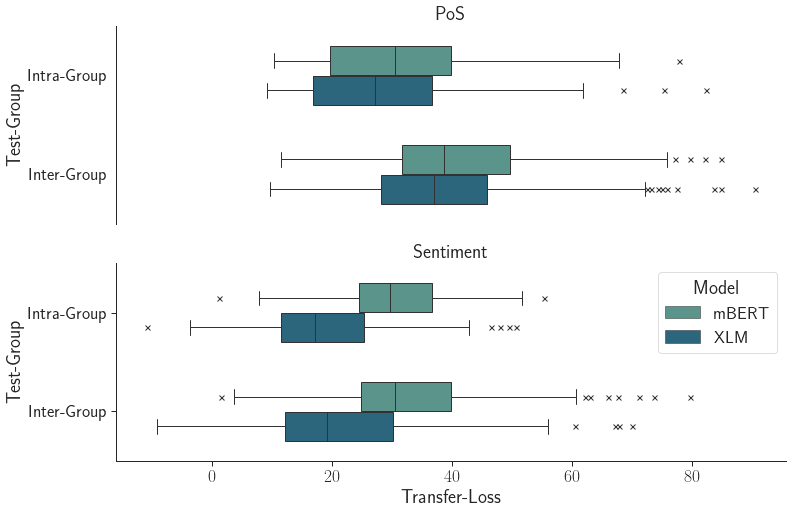

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

g1 = sns.boxplot(x="Transfer-Loss", 
                y="Test-Group", 
                data=df[df["Task"] == "Part-of-Speech"], 
                hue="Model", 
                orient="h", 
                ax=ax[0], 
                palette="crest", 
                width=0.6,
                linewidth=1,
                flierprops={"marker": "x"})

ax[0].set_title("PoS")
leg = ax[0].get_legend()
leg.set_visible(False)
ax[0].set_xlabel("")
ax[0].tick_params(color="white")

sns.despine(ax=ax[0], bottom=True)

g2 = sns.boxplot(x="Transfer-Loss", 
                y="Test-Group", 
                data=df[df["Task"] == "Sentiment Analysis"], 
                hue="Model", 
                orient="h", 
                ax=ax[1], 
                palette="crest", 
                width=0.6,
                linewidth=1,
                flierprops={"marker": "x"})

ax[1].set_title("Sentiment")

sns.despine(ax=ax[1])
plt.show()
plt.close()